Inspiration of this notebook: a CGP Grey video about how machines learn

In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *

In [ ]:
def search_images(term, max_images=30):
  return L(DDGS().images(term, max_results=max_images)).itemgot('image')

In [ ]:
%%bash

if [ -d images ]; then
    rm -r images
fi

In [ ]:
from time import sleep
import shutil

path = Path("images")

test_categories = {
  'bee': 'images of bees',
  'three': 'images of number 3',
  'tree': 'images of trees',
  'humvee': 'images of humvees',
}

train_categories = {
  'bee': 'hình con ông',
  'three': 'pictures of the number three',
  'tree': 'hình cây',
  'humvee': 'hình xe humvee quân đội',
}

data = {
  'train': train_categories,
  'test': test_categories,
}

for data_type, categories in data.items():
  for category, search_term in categories.items():
    dest = path / data_type / category
    shutil.rmtree(dest, ignore_errors=True)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(search_term, max_images=50))
    resize_images(dest, max_size=400, dest=dest)
    sleep(2)

/root/.cache/pypoetry/virtualenvs/bee-or-three-jOM-MOio-py3.10/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/bee-or-three-jOM-MOio-py3.10/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/bee-or-three-jOM-MOio-py3.10/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/bee-or-three-jOM-MOio-py3.10/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/.cache/pypoetry/virtualenvs/bee-or-three-jOM-MOio-py3.10/lib/python3.10/site-packages/

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

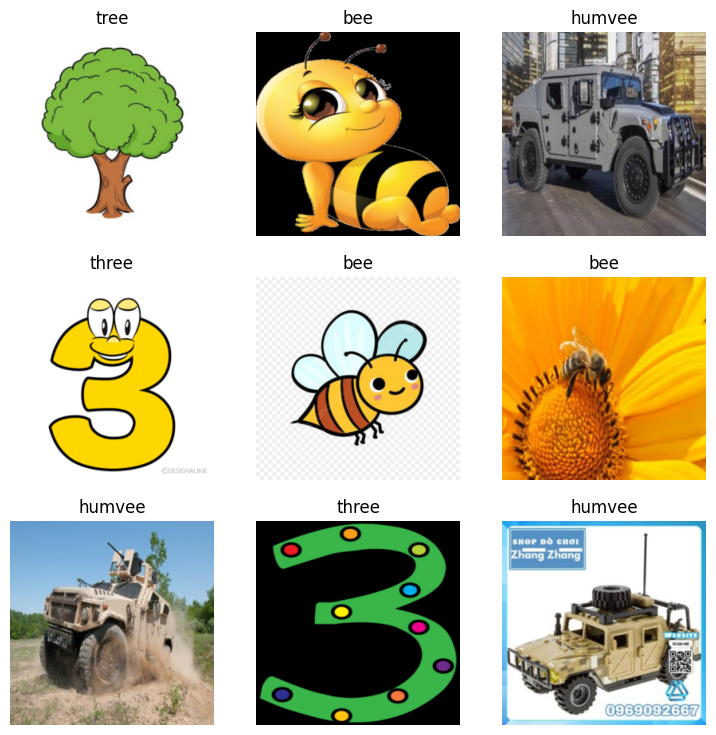

In [ ]:
# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     get_items=get_image_files,
#     splitter=RandomSplitter(valid_pct=0.25, seed=42),
#     get_y=parent_label,
#     item_tfms=[Resize(256, method='squish')]
# ).dataloaders(path, bs=32)

dls = ImageDataLoaders.from_path_func(
    path, get_image_files(path / "train"),
    valid_pct=0.25, label_func=parent_label,
    item_tfms=[Resize(256, method='squish')],
    bs=32
)

dls.show_batch(max_n=9)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

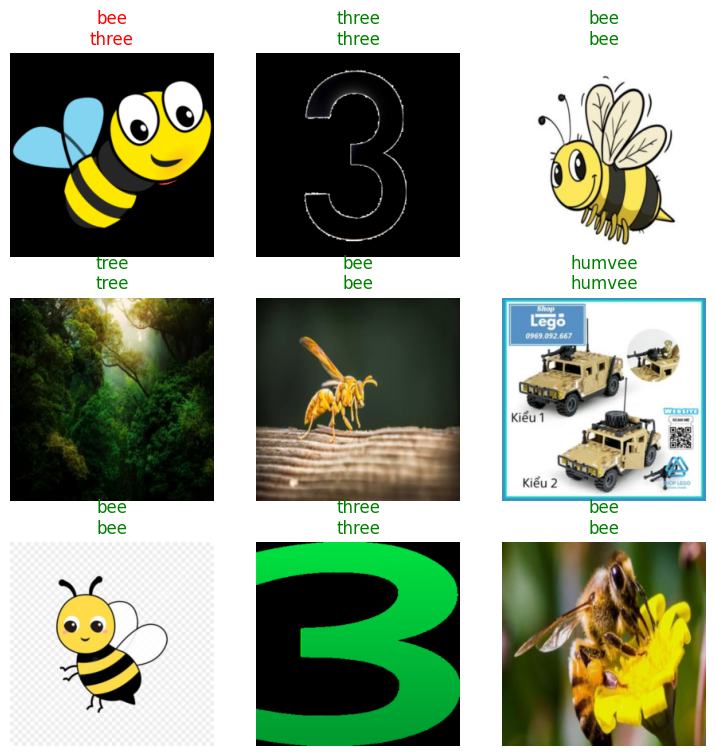

In [ ]:
learn.show_results()

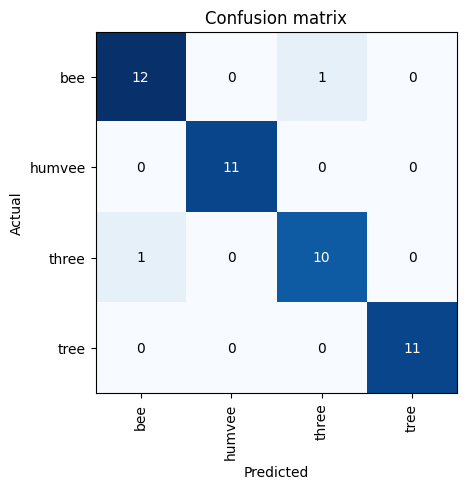

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

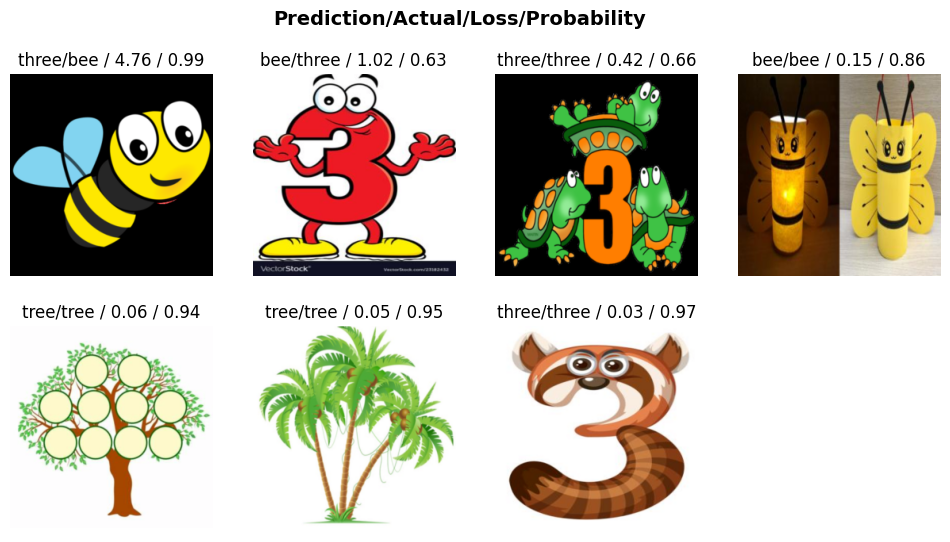

In [ ]:
interp.plot_top_losses(7)

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# Delete all files that we say we delete
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [ ]:
# Move all files that are wrongly categorized
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

Now, we go back to that Dataloaders again and repeat

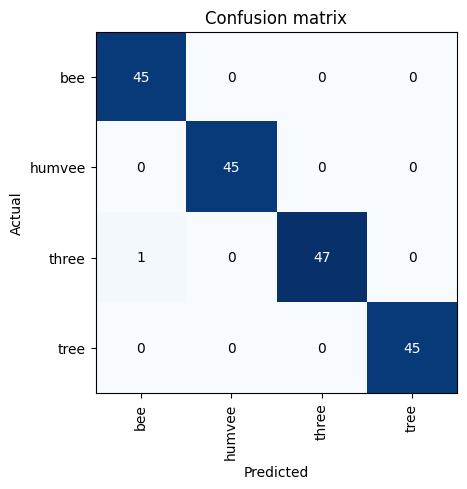

In [ ]:
fnames = get_files(path / "test")
dl = learn.dls.test_dl(fnames, with_labels=True)
interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_confusion_matrix()

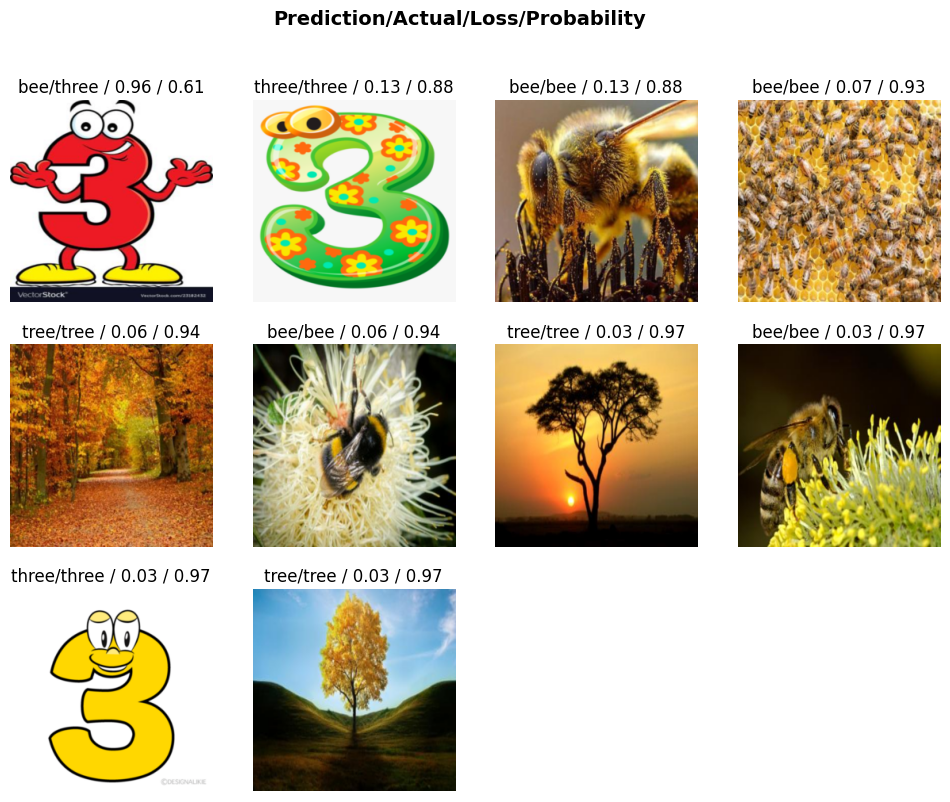

In [ ]:
interp.plot_top_losses(10)

In [ ]:
learn.export('../model.pkl')